#Sentiment Analysis of tweets during an NBA playoff game
Github: https://github.com/deepnadevkar/twittersentimentanalysis <p>
Blog: http://www.deepnadevkar.com/blogs/post/Twitter-Sentiment-Analysis-of-Rockets%C2%A0during-an-NBA-playoff-game/ <p>
<p>

We live in a world of social media and big data, where a huge amount of data is available to us that cannot be analyzed manually. Businesses are really interested in capturing a general emotional trend or attitude about their products, watch how it changes over time, and understand how it relates to their competitors. There is a huge push in the field of data science to come up with better tools for sentiment analysis. I had never worked with textual data before and the field of NLP is really exciting to me! I thought that it would be really interesting to do a basic sentiment analysis about a popular event that is happening in real-time!During the time that I was thinking about this, it was NBA playoffs season and there was a timely game coming up -- Rockets vs Warriors (Game 2; the Rockets lost :-(). I thought it would be awesome to collect information expressed through a big social media platform while the game is happening and then analyze how the sentiment of avid sports fans changed throughout the game. 

###[I. Collect data during the game](https://github.com/deepnadevkar/twittersentimentanalysis/blob/master/tweetstreaming.py)
- Access the Twitter Streaming API
- Collect live tweets with keyword "rockets" and store them into a mongodb database
- Used Robomongo (a GUI for mongodb) to watch incoming tweets 
- Export database as a .json file
<img src="tweetstreamingscript.png">

###[II. Read, Clean and Preprocess Data](https://github.com/deepnadevkar/twittersentimentanalysis/blob/master/readandclean_rockets.ipynb)  

###[III. Data Visualizations](https://github.com/deepnadevkar/twittersentimentanalysis/blob/master/rockets_basicanalysis.ipynb)

<a id= 'top'></a>
###[IV. Sentiment Analysis](#4)
- [Movie Reviews Corpus](#4-1)
- [Training and Testing Twitter Sentiment Corpus](#4-2)
    - [<font color='green'>Random Forests</font>](#4-2-1)
    - [<font color='green'>Multinomial Naive Bayes</font>](#4-2-2)
    - [<font color='green'>Support Vector Machine</font>](#4-2-3)
- [Predicting Sentiment based on trained model](#4-3)
    - [<font color='green'>Positive vs. Negative Sentiment Count </font>](#mnbpred-fig)
- [Predicting Sentiment Score using Textblob](#4-4)
    - [<font color='green'>Distribution of Sentiment Score </font>](#sent-dist)
    - [<font color='green'>Positive, Negative, and Neutral Sentiment Count </font>](#textblob-bar)
    - [<font color='green'>Sentiment Over Time </font>](#sent-overtime)
     
###V. Conclusions
- Add here later

<a id= '4'></a>
##IV. Sentiment Analysis
<a id= '4-1'></a>
###Movie Reviews Corpus
- 2000 movie reviews classified as positive or negative 
- Trained with a Naive Bayes Classifier, accracy is about 73%
- Two main issues:
    - [differs in its precision and recall](http://streamhacker.com/2010/05/17/text-classification-sentiment-analysis-precision-recall/) for positive versus negative reviews. 
    <img src="moviereviewscorpus.png">
    - movie reviews can be quite lengthy with more information, whereas tweets are only 140 characters long and may have a lot more slangs and emoticons than movie reviews. This might not be the best corpus for my data  

<a id= '4-2'></a>
###Training and Testing Twitter Sentiment Corpus

I found a [Twitter Sentiment Analysis corpus](http://thinknook.com/twitter-sentiment-analysis-training-corpus-dataset-2012-09-22/), which contains over a million tweets that are classified as positive (1) and negative (0). But, before I used this corpus on my dataset, I wanted to first test how good it was.
<p>
I used the same method for cleaning and preprocessing the text as mentioned in Step II above. The pertaining code can be found [here](https://github.com/deepnadevkar/twittersentimentanalysis/blob/master/twittersentiment_corpus.ipynb). I ended up using only a small fraction of this corpus (100,000 tweets) due to computational limitations. The code for making this smaller corpus can be found [here](https://github.com/deepnadevkar/twittersentimentanalysis/blob/master/makesmallercorpus.ipynb)

In [1]:
# Imports
import pandas as pd
from pandas import DataFrame, Series
from pandas.tseries.resample import TimeGrouper
from pandas.tseries.offsets import DateOffset
import numpy as np
import json
import sklearn 
import seaborn as sns
sns.set_style('whitegrid')
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# note that here I used the mini corpus with 100,000 datapoints for computational reasons
clean_corpus = pd.read_csv('clean_corpus_mini.csv')

In [3]:
clean_corpus.head()

,Sentiment,CleanText
0,0,pembsdave happening
1,0,brhodes u didnt invite hope u enough drinks us
2,0,house watching tv mommy boys gone drinking jui...
3,0,germany lost another time song wasn bad
4,1,cliff nervous bladder


In [4]:
clean_corpus.shape

(100000, 2)

In [5]:
# there may be some missing values in cleantext; drop those
clean_corpus.dropna(inplace = True)

In [6]:
clean_corpus.shape

(99875, 2)

In [7]:
# Split the data for training (90% of data) and testing (10% of data)

from sklearn.cross_validation import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(clean_corpus['CleanText'], clean_corpus['Sentiment'],test_size=0.1)

In [8]:
print (X_train.shape, X_test.shape, Y_train.shape , Y_test.shape)

(89887,) (9988,) (89887,) (9988,)


In [9]:
# Create bag of words for training data

from sklearn.feature_extraction.text import TfidfVectorizer

In [10]:
# Initialize the "TfidfVectorizer" object, which is refined sklearn's bag of words tool.  
# It first divides the number of occurrences of each word in a document by the total number of words in the document: 
# these new features are called tf for Term Frequencies.
# Another refinement on top of tf is to downscale weights for the less informativr words that occur in the corpus
# than those that occur only in a smaller portion of the corpus.
# This downscaling is called tf–idf for “Term Frequency times Inverse Document Frequency”.

vectorizer = TfidfVectorizer(analyzer = "word",tokenizer = None,preprocessor = None, stop_words = None,
                             max_features = 5000) 

In [11]:
# fit_transform() does two functions: First, it fits the model and learns the vocabulary; second, it transforms our 
# training data into feature vectors. 

# The input to fit_transform should be a list of strings.
X_train_list = X_train.tolist()

# now we can use the fit_transform function
train_data_features = vectorizer.fit_transform(X_train_list)

# Numpy arrays are easy to work with, so convert the result to an array
train_data_features = train_data_features.toarray()

print ('train_data_features done')

train_data_features done


In [12]:
# Get a bag of words for the test set, and convert to a numpy array

X_test_list = X_test.tolist()

# VERY IMPORTANT: On test data, we ONLY use transform... we DO NOT FIT IT! 
test_data_features = vectorizer.transform(X_test_list)
test_data_features = test_data_features.toarray()

print ('test_data_features done')

test_data_features done


In [13]:
train_data_features.shape

(89887, 5000)

In [14]:
test_data_features.shape

(9988, 5000)

In [15]:
Y_test.mean() # null error rate 

0.52342811373648379

<a id= '4-2-1'></a>
###Random Forest

In [18]:
'''from sklearn.ensemble import RandomForestClassifier

# Initialize a Random Forest classifier with 100 trees
forest = RandomForestClassifier(n_estimators = 100) 

# Fit the forest to the training set, using the bag of words as features and the sentiment labels as the response 
# variable

# This may take a few minutes to run
forest = forest.fit( train_data_features, Y_train )

test_pred = forest.predict(test_data_features)'''

'from sklearn.ensemble import RandomForestClassifier\n\n# Initialize a Random Forest classifier with 100 trees\nforest = RandomForestClassifier(n_estimators = 100) \n\n# Fit the forest to the training set, using the bag of words as features and the sentiment labels as the response \n# variable\n\n# This may take a few minutes to run\nforest = forest.fit( train_data_features, Y_train )\n\ntest_pred = forest.predict(test_data_features)'

In [19]:
'''train_score = forest.score(train_data_features, Y_train)
test_score = forest.score(test_data_features, Y_test)

print (train_score) #0.9843
print (test_score)  #0.7478'''

'train_score = forest.score(train_data_features, Y_train)\ntest_score = forest.score(test_data_features, Y_test)\n\nprint (train_score) #0.9843\nprint (test_score)  #0.7478'

In [20]:
'''# confusion matrix and a classification report

from sklearn import metrics
from sklearn.cross_validation import cross_val_score

print (metrics.confusion_matrix(Y_test, test_pred))
print (metrics.classification_report(Y_test, test_pred))'''

'# confusion matrix and a classification report\n\nfrom sklearn import metrics\nfrom sklearn.cross_validation import cross_val_score\n\nprint (metrics.confusion_matrix(Y_test, test_pred))\nprint (metrics.classification_report(Y_test, test_pred))'

<a id= '4-2-2'></a>
### Multinomial Naive Bayes

In [21]:
from sklearn.naive_bayes import MultinomialNB

# Initialize a Multinomial NB classifier 
mnb = MultinomialNB() 

# Fit the MNB classifier to the training set, using the bag of words as features and the sentiment labels as the 
# response variable

# This may take a few minutes to run
mnb = mnb.fit( train_data_features, Y_train )

mnb_test_pred = mnb.predict(test_data_features)

In [22]:
# MNB test accuracy 

mnb_test_score = mnb.score(test_data_features, Y_test)

print (mnb_test_score)

0.753804565479


In [23]:
from sklearn import metrics
from sklearn.cross_validation import cross_val_score

print (metrics.confusion_matrix(Y_test, mnb_test_pred))
print (metrics.classification_report(Y_test, mnb_test_pred))

[[3297 1463]
 [ 996 4232]]
             precision    recall  f1-score   support

          0       0.77      0.69      0.73      4760
          1       0.74      0.81      0.77      5228

avg / total       0.75      0.75      0.75      9988



<a id= '4-2-3'></a>
###Support Vector Machine

In [24]:
from sklearn.linear_model import SGDClassifier

# Initialize a SVM classifier 
svm = SGDClassifier()

# Fit the SVM classifier to the training set, using the bag of words as features and the sentiment labels as the 
# response variable

# This may take even longer to run than the MNB 
svm = svm.fit( train_data_features, Y_train )

svm_test_pred = svm.predict(test_data_features)

In [25]:
# SVM test accuracy 

svm_test_score = svm.score(test_data_features, Y_test)

print (svm_test_score)

0.752803364037


In [26]:
print (metrics.confusion_matrix(Y_test, svm_test_pred))
print (metrics.classification_report(Y_test, svm_test_pred))

[[3064 1696]
 [ 773 4455]]
             precision    recall  f1-score   support

          0       0.80      0.64      0.71      4760
          1       0.72      0.85      0.78      5228

avg / total       0.76      0.75      0.75      9988



<a id= '4-3'></a>
###Predicting Sentiment based on trained model
All three classifier's had around 75% accuracy score. However, since the MNB classifier had the most balanced precision and recall scores for positive and negative reviews, I used the MNB classifier to predict sentiment scores on my tweets. 

In [27]:
clean_tweets = pd.read_csv('rockets_cleantext.csv', header = False)

In [28]:
clean_tweets.shape

(105783, 1)

In [29]:
clean_tweets.head()

,CleanText
0,getting ready game rockets vs warriors warrior...
1,iamc mart lil b curse james harden curtains ro...
2,tonight free pick houston rockets u
3,let go rockets
4,rockets boutta win game


In [30]:
# there may be some missing values in in rockets_data_features; drop those
clean_tweets.dropna(inplace = True)

In [31]:
clean_tweets.shape

(105783, 1)

In [32]:
# The input to transform should be a list of strings.
rockets_list = clean_tweets['CleanText'].values.tolist()

In [33]:
rockets_list[0:5]

['getting ready game rockets vs warriors warriors spashbros nba basketball besureinc co glrexsuchm',
 'iamc mart lil b curse james harden curtains rockets',
 'tonight free pick houston rockets u',
 'let go rockets',
 'rockets boutta win game']

In [34]:
# get the bag of words on the rockets tweets
rockets_data_features = vectorizer.transform(rockets_list)

In [35]:
rockets_data_features.shape

(105783, 5000)

In [36]:
rockets_data_features = rockets_data_features.toarray()

In [37]:
# now run the multinomial NB model to predict sentiment values for the rockets

mnb_rockets_pred = mnb.predict(rockets_data_features)

In [38]:
mnb_rockets_pred[0:5]

array([1, 0, 1, 1, 1])

In [39]:
clean_tweets['Sentiment'] = mnb_rockets_pred

In [40]:
clean_tweets[0:15]

,CleanText,Sentiment
0,getting ready game rockets vs warriors warrior...,1
1,iamc mart lil b curse james harden curtains ro...,0
2,tonight free pick houston rockets u,1
3,let go rockets,1
4,rockets boutta win game,1
5,complexmag rockets fans begging lil b put base...,1
6,lildelvin rockets take l today,1
7,sportscenter rockets warriors meet game et esp...,1
8,nah cuh chill co qqrlnevt,1
9,rjthamacrj rockets play warriors hope kevin mc...,1


In [41]:
pos = clean_tweets[clean_tweets['Sentiment'] == 1]

In [42]:
pos.shape

(65284, 2)

In [43]:
neg = clean_tweets[clean_tweets['Sentiment'] == 0]

In [44]:
neg.shape

(40499, 2)

In [45]:
clean_tweets.to_csv('twittercorpus_sentiment.csv',index = False)

In [46]:
pos.head()

,CleanText,Sentiment
0,getting ready game rockets vs warriors warrior...,1
2,tonight free pick houston rockets u,1
3,let go rockets,1
4,rockets boutta win game,1
5,complexmag rockets fans begging lil b put base...,1


In [47]:
clean_tweets['Sentiment Category'] = clean_tweets.Sentiment.map({0: "Negative", 1: "Positive"})

<a id= 'mnbpred-fig'></a>

<a id= 'mnb-pred'></a>

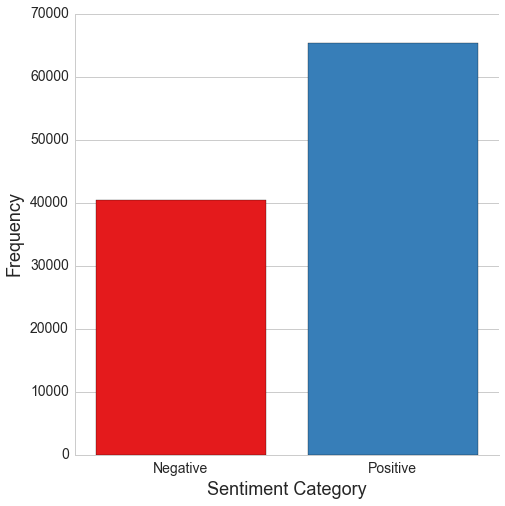

In [48]:
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
sns.factorplot('Sentiment Category',data=clean_tweets,palette='Set1', size = 7, aspect = 1)

plt.xlabel('Sentiment Category', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)

<a id= '4-4'></a>
###Sentiment Analysis using Textblob 

In [49]:
from textblob import TextBlob, Word

In [50]:
sentiments = [TextBlob(tweet).sentiment.polarity for tweet in clean_tweets['CleanText']]

In [51]:
print (clean_tweets['CleanText'][0:15], sentiments[0:15])

0     getting ready game rockets vs warriors warrior...
1     iamc mart lil b curse james harden curtains ro...
2                   tonight free pick houston rockets u
3                                        let go rockets
4                               rockets boutta win game
5     complexmag rockets fans begging lil b put base...
6                        lildelvin rockets take l today
7     sportscenter rockets warriors meet game et esp...
8                             nah cuh chill co qqrlnevt
9     rjthamacrj rockets play warriors hope kevin mc...
10    sportscenter draymond green enters arena game ...
11                                     warriors rockets
12                     rjack lock warriors rockets game
13    sportscenter rockets warriors meet game et esp...
14    espnstatsinfo rockets howard lineup postseason...
Name: CleanText, dtype: object [-0.1, 0.0, 0.4, 0.0, 0.2, 0.0, 0.0, -0.1, 0.0, -0.4, -0.12500000000000003, 0.0, -0.4, -0.1, 0.0]


In [52]:
avg_sentiment = np.sum(sentiments)/len(sentiments)
print (avg_sentiment)

0.0544129545809


<a id= 'sent-dist'></a>

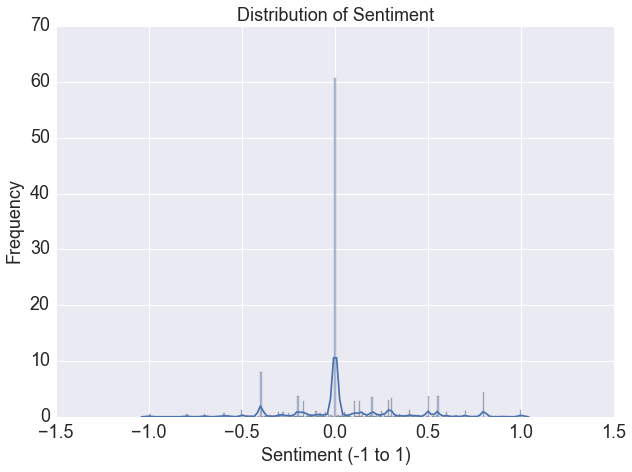

In [64]:
sns.set_style('darkgrid')
plt.figure(num=None, figsize=(10, 7), dpi=300)
ax = plt.subplot()
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)
sns.distplot(sentiments)
plt.title('Distribution of Sentiment', fontsize = 18)
plt.xlabel('Sentiment (-1 to 1)')
plt.ylabel('Frequency')
plt.show()

In [54]:
# Loop through all of the sentiments and put them into the appropriate group
pos_neg_neutral = []
for sentiment in sentiments:
    if sentiment <= -0.25:
        pos_neg_neutral.append('Negative')
    elif sentiment >= 0.25:
        pos_neg_neutral.append('Positive')
    elif sentiment > -0.25 and sentiment < 0.25:
        pos_neg_neutral.append('Neutral')
clean_tweets['Sentiment Category'] = np.array(pos_neg_neutral)

In [55]:
clean_tweets[0:5]

,CleanText,Sentiment,Sentiment Category
0,getting ready game rockets vs warriors warrior...,1,Neutral
1,iamc mart lil b curse james harden curtains ro...,0,Neutral
2,tonight free pick houston rockets u,1,Positive
3,let go rockets,1,Neutral
4,rockets boutta win game,1,Neutral


<a id= 'textblob-bar'></a>

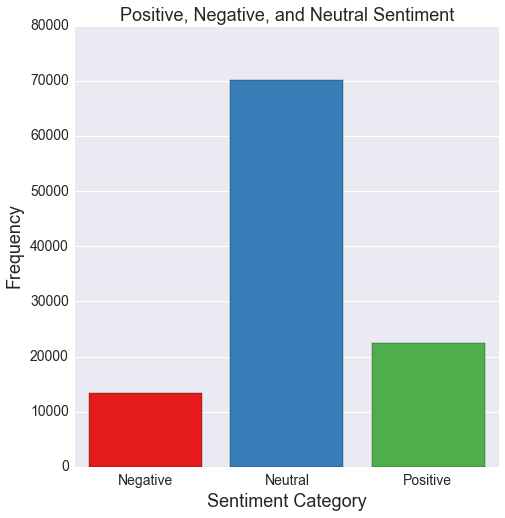

In [56]:
sns.set_style('darkgrid')
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)
sns.factorplot('Sentiment Category',data=clean_tweets, size = 7, aspect = 1, palette = 'Set1')
plt.title('Positive, Negative, and Neutral Sentiment', fontsize = 18)
plt.xlabel('Sentiment Category', fontsize = 18)
plt.ylabel('Frequency', fontsize = 18)

In [57]:
clean_tweets['Sentiment'] = sentiments

In [58]:
path = 'rockets.json'
record = [json.loads(line) for line in open(path)]
rockets = DataFrame(record)

created_at = pd.read_csv('rockets_datetime.csv', header = 0) 
rockets['datetime'] = created_at
rockets.drop(['created_at','_id'], inplace=True, axis=1)
rockets['datetime'] = pd.to_datetime(pd.Series(rockets['datetime']))
rockets.set_index('datetime', drop=False, inplace=True)
rockets.index = rockets.index.tz_localize('UTC').tz_convert('EST')
rockets.index = rockets.index - DateOffset(hours = 12)
clean_tweets.index = rockets.index
clean_tweets.head()

,CleanText,Sentiment,Sentiment Category
2015-05-21 07:45:44-05:00,getting ready game rockets vs warriors warrior...,-0.1,Neutral
2015-05-21 07:45:45-05:00,iamc mart lil b curse james harden curtains ro...,0.0,Neutral
2015-05-21 07:45:46-05:00,tonight free pick houston rockets u,0.4,Positive
2015-05-21 07:45:46-05:00,let go rockets,0.0,Neutral
2015-05-21 07:45:46-05:00,rockets boutta win game,0.2,Neutral


In [59]:
sentiment1m = clean_tweets['Sentiment'].resample('1t', how='mean')
#sentiment5m = clean_tweets['Sentiment'].resample('5t', how='mean')
#sentiment20m = clean_tweets['Sentiment'].resample('20t', how='mean')

<a id= 'sent-overtime'></a>

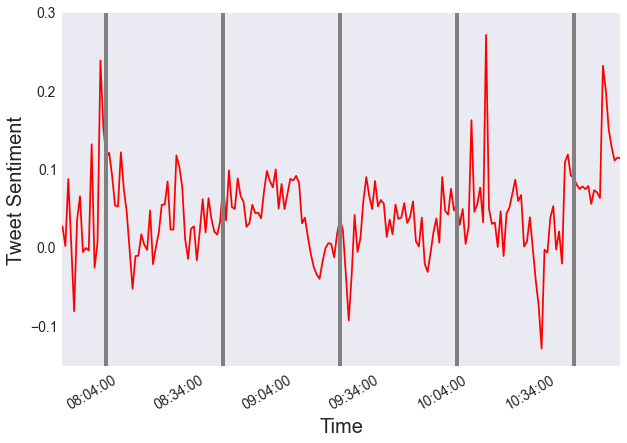

In [60]:
fig, ax = plt.subplots()
sentiment1m.plot(legend=False,figsize=(10,7), color = 'red')
#sentiment5m.plot(legend=False,figsize=(15,10), color = 'blue')
#sentiment20m.plot(legend=False,figsize=(15,10), color = 'green')
plt.setp(ax.get_xticklabels(),fontsize=14,family='sans-serif')
plt.setp(ax.get_yticklabels(),fontsize=14,family='sans-serif')
plt.xlabel('Time',fontsize=20,family='sans-serif')
plt.ylabel('Tweet Sentiment',fontsize=20,family='sans-serif')
# Now add the start and end markers
plt.axvline(x='2015-05-21 08:00:00-05:00', linewidth=4, color='grey')
plt.axvline(x='2015-05-21 08:40:00-05:00', linewidth=4, color='grey')
plt.axvline(x='2015-05-21 09:20:00-05:00', linewidth=4, color='grey')
plt.axvline(x='2015-05-21 10:00:00-05:00', linewidth=4, color='grey')
plt.axvline(x='2015-05-21 10:40:00-05:00', linewidth=4, color='grey')
plt.grid(False)
plt.show()

In [61]:
print (clean_tweets['Sentiment'].min())
print (clean_tweets['Sentiment'].max())

-1.0
1.0


In [62]:
print (clean_tweets[clean_tweets['Sentiment']==clean_tweets['Sentiment'].min()]['CleanText'].values[0])

bigtrain ya boring watching rockets blowing teams


In [63]:
print (clean_tweets[clean_tweets['Sentiment']==clean_tweets['Sentiment'].max()]['CleanText'].values[0])

best chef world dynamite bounds flavor town mayor co xwwixgxgbm


[Scroll to top](#top)